# Making imports


In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import sys
import random
import scipy.optimize as opt
from scipy import stats
import torch
from tqdm import tqdm

random.seed(19680801)
np.random.seed(19680801)
torch.manual_seed(19680801)
torch.cuda.manual_seed(19680801)
torch.backends.cudnn.deterministic = True

# Task 3

# Class for storing coords

In [2]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y

# Defining optimization methods

In [3]:
def exhaustive_search(func, a, b, e = 0.001):
    optim_point = Point(math.inf, math.inf)
    
    n = int((b - a) / e)
    step = (b - a) / n
    
    for k in range(0, n):
        x_k = a + k * step
        y_k = func(x_k)
        
        if optim_point.y > y_k:
            optim_point = Point(x_k, y_k)
    
    iter_count = n
    f_calc_count = n

    return optim_point, iter_count, f_calc_count

## Generate random array

In [4]:
a = random.random()
b = random.random()

print(a, b)

0.18054507069218806 0.5676159350662024


In [5]:
x = np.linspace(0, 101, 101) / 100
sigma = np.random.normal(0, 1, 101)

y = a * x + b + sigma

# Some more functions for graphs

In [169]:
colors = ['b','g','r','c','m','y','k']

def plot_aprox_result(x, y, methods_and_coafs, aprox_func, aprox_method_name, plot_full_only = False, figsize=(6,10)):
    
    if plot_full_only:
       num_of_plots = 1
    else:
        num_of_plots = len(methods_and_coafs) + 1

    fig, ax = plt.subplots(num_of_plots, figsize=figsize)
    
    fig.suptitle(aprox_method_name)
    
    if not plot_full_only:
        for idx, (method) in enumerate(methods_and_coafs) :
            ax[idx].scatter(x, y)
            coef = methods_and_coafs[method]
            
            color = colors[idx]
            ax[idx].plot(x, aprox_func(x, coef[0], coef[1] ), label=method, color=color)
            ax[idx].set(xlabel='x', ylabel='y')
        
            ax[idx].legend()
            ax[idx].grid()
        
        num_of_plots -= 1
        ax[num_of_plots].scatter(x, y)
        ax[num_of_plots].set(xlabel='x', ylabel='y')

        for idx, (method) in enumerate(methods_and_coafs):
        
            coef = methods_and_coafs[method]
            print(coef)

            color = colors[idx]
            ax[num_of_plots].plot(x, aprox_func(x, coef[0], coef[1] ), label=method, color=color)

            ax[num_of_plots].legend()
            ax[num_of_plots].grid()
    else:
        ax.scatter(x, y)
        ax.set(xlabel='x', ylabel='y')
        
        for idx, (method) in enumerate(methods_and_coafs):
        
            coef = methods_and_coafs[method]
            print(coef)
            
            color = colors[idx]
            ax.plot(x, aprox_func(x, coef[0], coef[1] ), label=method, color=color)
        
            ax.legend()
            ax.grid()
        
    plt.show()

In [7]:
def make_table_2d(table_data,
               row_headers = ['exhaustive_search_2d','Gauss','Nelder-Mead'],
               column_headers = ['iter_count','f_calc_count', 'squared error']):
    
    for data in table_data:
        data[2] = round(data[2], 2)
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=table_data,
        rowLabels=row_headers,
        colLabels=column_headers,
        loc='center',
        cellLoc='center')

    plt.show()

# Defining loss functions for regression

In [170]:
def linear(x, a, b): 
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

#Spesial version for loss to use in scipy optimisation
def loss_linear(z, *params): 
    x, y = params
    a, b = z
    return np.sum((linear(x, a, b) - y)**2)

#Functional version for loss to calc precision
def f_loss_linear(x, y, a, b): 
    return np.sum((linear(x, a, b) - y)**2)

#Spesial version for loss to use in scipy optimisation
def loss_rational(z, *params): 
    x, y = params
    a, b = z
    return np.sum((rational(x, a, b) - y)**2)

#Functional version for loss to calc precision
def f_loss_rational(x, y, a, b): 
    return np.sum((rational(x, a, b) - y)**2)


#Spesial version for loss to use in LMA method
def loss_linear_lma(z, *params): 
    x, y = params
    a, b = z
    return linear(x, a, b) - y

#Spesial version for loss to use in LMA method
def loss_rational_lma(z, *params): 
    x, y = params
    a, b = z
    return rational(x, a, b) - y

# Calculating regression coefs by different methods

# Brute force method linear

In [9]:
brute_force = opt.brute(loss_linear, ([0,1],[0,1]), args=(x,y),  Ns = 1000, full_output=True)

In [10]:
brute_force_coafs = brute_force[0]
grid_size_x, grid_size_y = len(brute_force[2][0]), len(brute_force[2][0])
brute_froce_iter_count =  grid_size_x * grid_size_y
brute_force_f_calc_count = brute_froce_iter_count
brute_force_precision = f_loss_linear(x, y, brute_force_coafs[0], brute_force_coafs[1])

In [13]:
brute_force_result = [brute_froce_iter_count, brute_force_f_calc_count, brute_force_precision]

# Brute force method rational

In [11]:
brute_force_rational = opt.brute(loss_rational, ([0,1],[0,1]), args=(x,y),  Ns = 1000, full_output=True)

In [12]:
brute_force_coafs_rational = brute_force_rational[0]
grid_size_x, grid_size_y = len(brute_force_rational[2][0]), len(brute_force_rational[2][0])
brute_froce_iter_count_rational =  grid_size_x * grid_size_y
brute_force_f_calc_count_rational = brute_froce_iter_count_rational
brute_force_precision_rational = f_loss_rational(x, y, brute_force_coafs_rational[0], brute_force_coafs_rational[1])

In [14]:
brute_force_result_rational = [brute_froce_iter_count_rational,
                               brute_force_f_calc_count_rational,
                               brute_force_precision_rational]

# Coordinate descent method

In [197]:
def get_loss_func(fix_coord, loss_type, coefs):
    if loss_type == 'rational':
        func = rational
    if loss_type == 'linear':
        func = linear

    if fix_coord == 'a':
        return lambda a: np.sum((func(x, a, coefs[1]) - y)**2)
    if fix_coord == 'b':
        return lambda b: np.sum((func(x, coefs[0], b) - y)**2)

def coordinate_descent(params, limits, loss_type, initial_guess=[0,0], e=0.00001):
    coefs = initial_guess
    min_loss_value = Point(float('inf'), float('inf'))
    iter_sum = 0
    func_calc_sum = 0
    
    iter = 0
    while True:
        iter += 1

        L = get_loss_func('a', loss_type, coefs)
        optim_point, iter_count, f_calc_count = exhaustive_search(L, *limits[0], e=e)
        coefs[0] = optim_point.x
        
        iter_sum += iter_count  
        func_calc_sum += f_calc_count
        
        L = get_loss_func('b', loss_type, coefs)
        optim_point, iter_count, f_calc_count = exhaustive_search(L, *limits[1], e=e)
        coefs[1] = optim_point.x
        
        iter_sum += iter_count  
        func_calc_sum += f_calc_count

        if abs(min_loss_value.y - optim_point.y) <= e :
            print(iter)
            break
        else:
            min_loss_value = optim_point

    return coefs, iter_sum, func_calc_sum
 

## Coordinate descent linear 

In [177]:
coord_descent_coefs,\
coord_descent_iter_sum,\
coord_descent_func_calc_sum = coordinate_descent((x, y), ((-1,1),(-1,1)),loss_type='linear')
coord_descent_precision = f_loss_linear(x, y, coord_descent_coefs[0], coord_descent_coefs[1])

coordinate_descent_result = [coord_descent_iter_sum, coord_descent_func_calc_sum, coord_descent_precision]
coord_descent_coefs

23


[-0.53, 0.905]

In [17]:
coordinate_descent_result

[64000, 64000, 97.56359519139004]

## Coordinate descent rational 

In [199]:
coord_descent_coefs_rational,\
coord_descent_iter_sum_rational,\
coord_descent_func_calc_sum_rational = coordinate_descent((x, y), ((-2,2),(-2,2)), loss_type='rational', e=0.001, initial_guess=[-1,1])
coord_descent_precision_rational = f_loss_rational(x, y, coord_descent_coefs[0], coord_descent_coefs[1]) 

coordinate_descent_result_rational = [coord_descent_iter_sum, coord_descent_func_calc_sum, coord_descent_precision]
coord_descent_coefs_rational

11


[1.0460000000000003, 1.528]

# Nelder-Mead linear

In [19]:
initial_guess = [0, 0]
nelder_mead = opt.minimize(loss_linear, initial_guess, args=(x,y), method='Nelder-Mead', tol = 0.001)

In [143]:
nelder_mead['x']

array([-0.53283982,  0.90649384])

In [20]:
nelder_mead_result = [nelder_mead['nit'], nelder_mead['nfev'], nelder_mead['fun']]

# Nelder-Mead rational

In [21]:
initial_guess = [0, 0]
nelder_mead_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='Nelder-Mead', tol = 0.001)

In [22]:
nelder_mead_result_rational = [nelder_mead_rational['nit'], nelder_mead_rational['nfev'], nelder_mead_rational['fun']]

# Visualising result of calculationg coefs

[-0.53258568  0.90646995]
[-0.53, 0.905]
[-0.53283982  0.90649384]


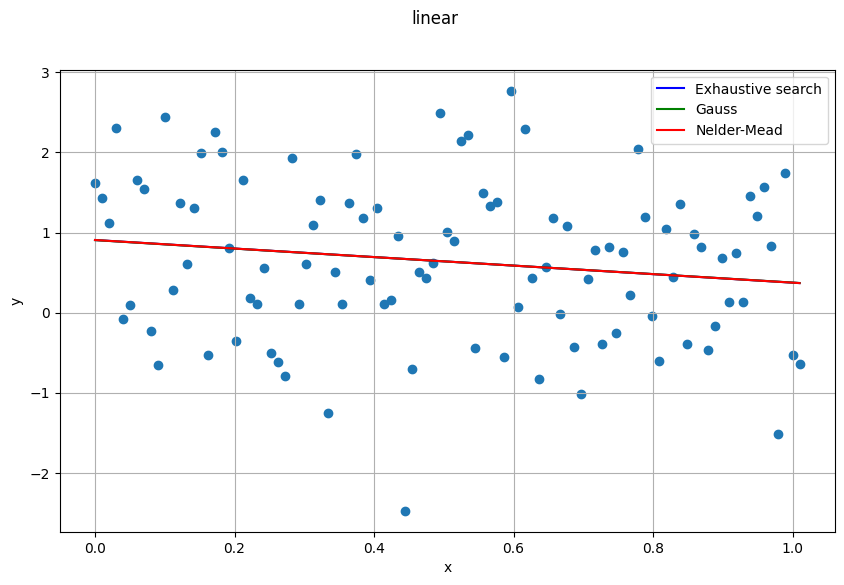

In [200]:
methods_and_coafs = {
    'Exhaustive search': brute_force_coafs,
    'Gauss': coord_descent_coefs,
    'Nelder-Mead': nelder_mead['x'],
}

plot_aprox_result(x, y, methods_and_coafs,linear, 'linear', plot_full_only=True, figsize=(10,6))

[1.05731824 1.57139123]
[1.0460000000000003, 1.528]
[1.05734698 1.57154923]


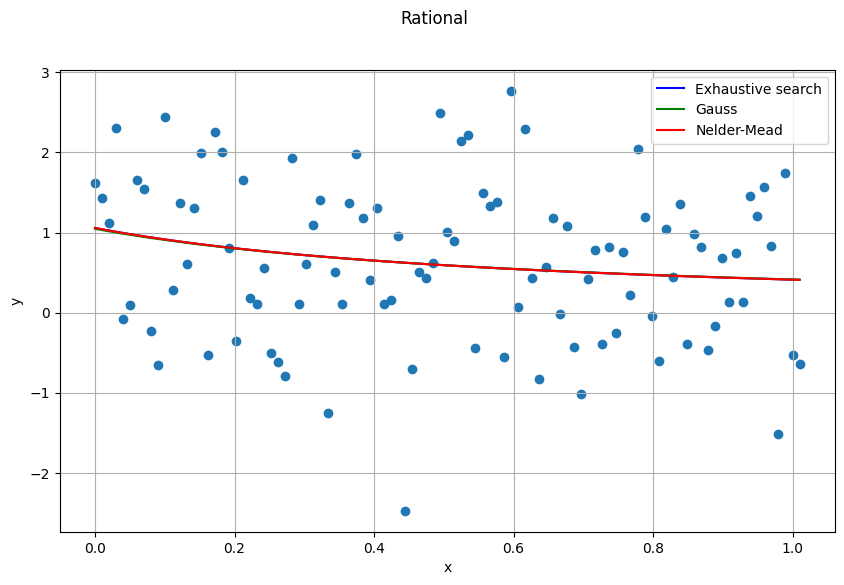

In [201]:
methods_and_coafs_rational = {
    'Exhaustive search': brute_force_coafs_rational,
    'Gauss': coord_descent_coefs_rational,
    'Nelder-Mead': nelder_mead_rational['x'],
}

plot_aprox_result(x, y, methods_and_coafs_rational, rational, 'Rational', plot_full_only=True, figsize=(10,6))

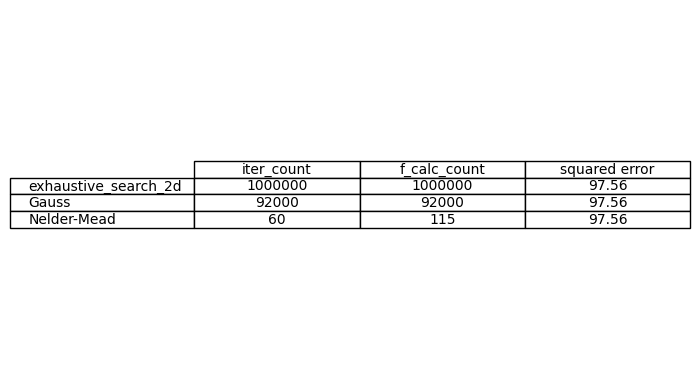

In [202]:
make_table_2d([brute_force_result,coordinate_descent_result,nelder_mead_result])

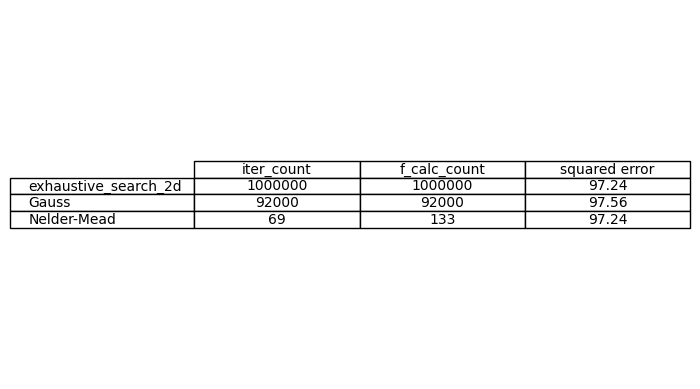

In [203]:
make_table_2d([brute_force_result_rational,coordinate_descent_result_rational,nelder_mead_result_rational])

# Gradient descent linear

In [109]:
class RegressionModel(torch.nn.Module):
    def __init__(self, reg_func, initial_point):

        super().__init__()
        self.reg_func = reg_func
        self.a = torch.nn.Parameter(torch.tensor(initial_point[0], dtype=float))
        self.b = torch.nn.Parameter(torch.tensor(initial_point[1], dtype=float))

    def forward(self, x):
        return self.reg_func(x, self.a, self.b)

    def string(self):
        return f'y = {self.a.item()} / (1 + {self.b.item()} * x)'

    def get_coefs(self):
        return self.a.item(), self.b.item()
    

def SGD(x, y, reg_func, initial_point=[0,0], lr=0.001, e=0.001, epoch_count=None, show_loss_graph=True):
    model = RegressionModel(reg_func, initial_point)

    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    loss_list = []

    X = torch.from_numpy(x)
    Y = torch.from_numpy(y)

    y_min = float('inf')
    y_pred = float('inf')

    epoch_count = 0
    while True:

    #for e in range(epoch_count):
        epoch_count += 1
        
        y_pred = model(X)
        
        loss = criterion(y_pred, Y)
        loss_list.append(loss.item())

        
        if abs(y_min - loss.item()) < e and epoch_count % 10 == 0:
            break
        else:
            y_min = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if show_loss_graph:
        plt.plot(loss_list, 'r')
        plt.tight_layout()
        plt.grid()
        plt.xlabel("Epochs/Iterations")
        plt.ylabel("Loss")
        plt.show()

    iter_num = epoch_count
    func_calc_num = epoch_count
    precision = loss_list[len(loss_list)-1]
    return *model.get_coefs(), iter_num, func_calc_num, precision

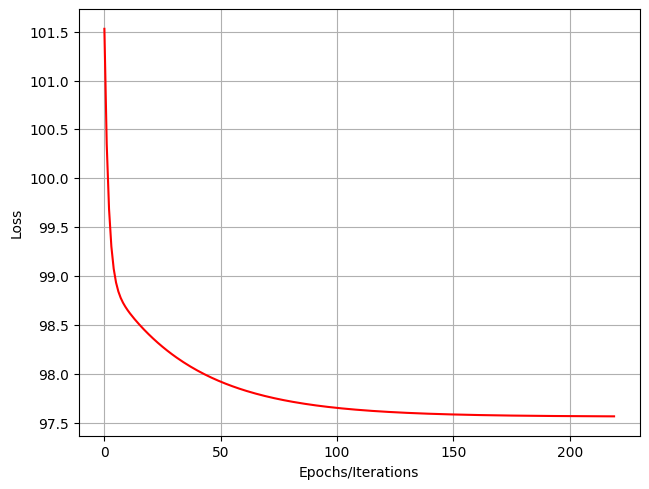

In [119]:
w, b, iter_num, func_calc_num, precision = SGD(x, y, linear, epoch_count=150, lr=0.001, e=0.0001, initial_point=[-1,1])

[-0.10617496  0.69415804]
[-0.104  0.693]
[-0.10585323  0.69401721]

In [112]:
SGD_result_linear = [iter_num, func_calc_num, precision]

# Gradient descent rational

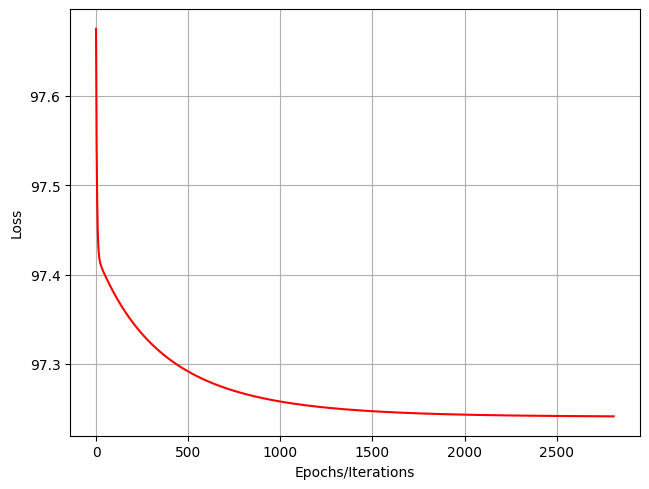

1.0502476461769794 1.5372808953857828


In [134]:
w_rational, b_rational, iter_num_rational, func_calc_num_rational, precision_rational = SGD(x, y, rational, epoch_count=300, lr=0.001, e=0.000001, initial_point=[1,1])
print(w_rational, b_rational)

In [135]:
SGD_result_rational = [iter_num_rational, func_calc_num_rational, precision_rational]

# Conjugate gradient linear

In [45]:
initial_guess = [0, 0]
conjugate_linear = opt.minimize(loss_linear, initial_guess, args=(x,y), method='CG', tol = 0.001)

In [47]:
conjugate_result_linear = [conjugate_linear['nit'], conjugate_linear['nfev'], conjugate_linear['fun']]

# Conjugate gradient rational

In [50]:
initial_guess = [-1, 1]
conjugate_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='CG', tol = 0.001)

In [51]:
conjugate_result_rational = [conjugate_rational['nit'], conjugate_rational['nfev'], conjugate_rational['fun']]

# Newton linear

In [52]:
initial_guess = [0, 0]
newton_linear = opt.minimize(loss_linear, initial_guess, args=(x,y), method='BFGS', tol=0.001)

In [53]:
newton_result_linear = [newton_linear['nit'], newton_linear['nfev'], newton_linear['fun']]

# Newton rational

In [54]:
initial_guess = [-1, 1]
newton_rational = opt.minimize(loss_rational, initial_guess, args=(x,y), method='BFGS')

In [55]:
newton_result_rational = [newton_rational['nit'], newton_rational['nfev'], newton_rational['fun']]

# Levenberg-Marquardt linear

In [103]:
c = 1e-6
initial_guess = [-1, 1]
lma_linear = opt.least_squares(loss_linear_lma, initial_guess, args=(x,y), method='lm', ftol = c , xtol = c , gtol=c, tr_solver='lsmr')

In [104]:
lma_result_linear = [len(lma_linear['fun']), lma_linear['nfev'], lma_linear['cost']]

# Levenberg-Marquardt rational

In [105]:
initial_guess = [-1, 1]
lma_rational = opt.least_squares(loss_rational_lma, initial_guess, args=(x,y), method='lm')

In [106]:
lma_result_rational = [len(lma_rational['fun']), lma_rational['nfev'], lma_rational['cost']]

# Plotting graphs for second order methods

[-0.5518855267081667, 0.9169341692975923]
[-0.53258587  0.90647574]
[-0.53258484  0.90647529]
[-0.53258487  0.90647532]


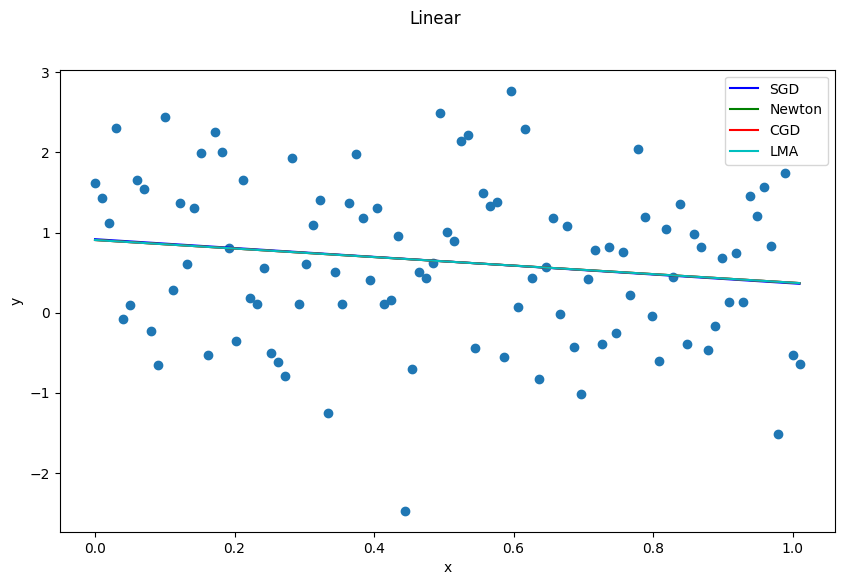

In [204]:
methods_and_coafs_first_order = {
    'SGD': [w, b],
    'Newton': newton_linear['x'],
    'CGD': conjugate_linear['x'],
    'LMA': lma_linear['x'],
}

plot_aprox_result(x, y, methods_and_coafs_first_order, linear, 'Linear', plot_full_only = True, figsize=(10, 6))

[1.0502476461769794, 1.5372808953857828]
[1.05730987 1.5713342 ]
[1.05730844 1.57132653]
[1.05726899 1.57113345]


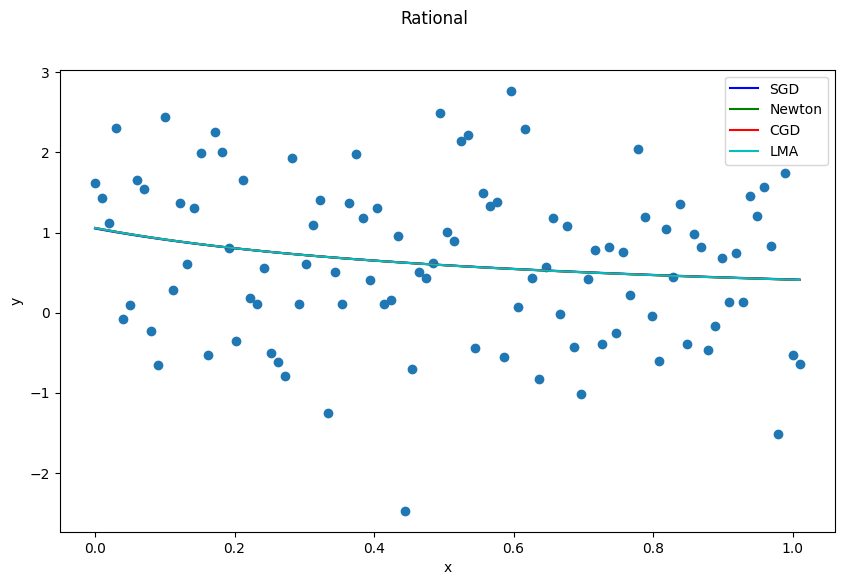

In [205]:
methods_and_coafs_rational_first_order = {
    'SGD': [w_rational, b_rational],
    'Newton': newton_rational['x'],
    'CGD': conjugate_rational['x'],
    'LMA': lma_rational['x'],
}

plot_aprox_result(x, y, methods_and_coafs_rational_first_order, rational, 'Rational', plot_full_only = True, figsize=(10, 6))

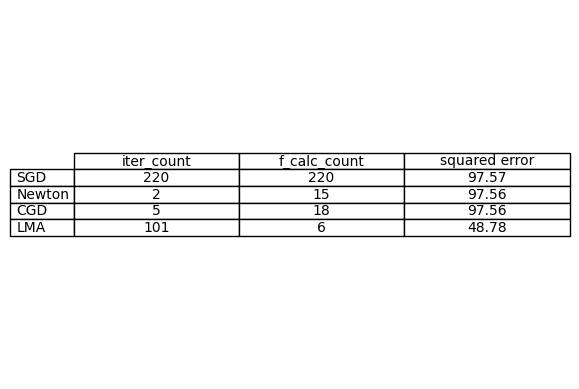

In [206]:
make_table_2d([SGD_result_linear, conjugate_result_linear, newton_result_linear, lma_result_linear],
               row_headers = list(methods_and_coafs_first_order.keys()),
               column_headers = ['iter_count','f_calc_count', 'squared error'])

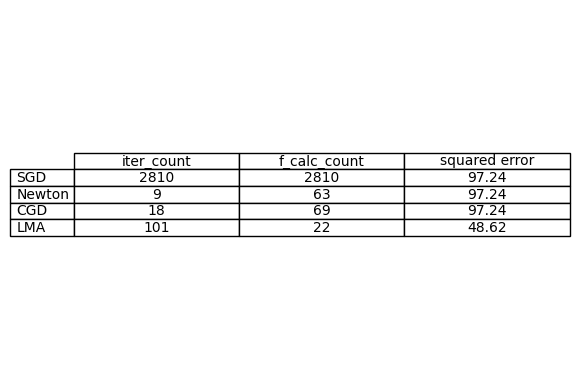

In [207]:
make_table_2d([SGD_result_rational, conjugate_result_rational, newton_result_rational, lma_result_rational],
               row_headers = list(methods_and_coafs_rational_first_order.keys()),
               column_headers = ['iter_count','f_calc_count', 'squared error'])

# Combined grahps

# Linear

[-0.53258568  0.90646995]
[-0.53, 0.905]
[-0.53283982  0.90649384]
[-0.5518855267081667, 0.9169341692975923]
[-0.53258587  0.90647574]
[-0.53258484  0.90647529]
[-0.53258487  0.90647532]


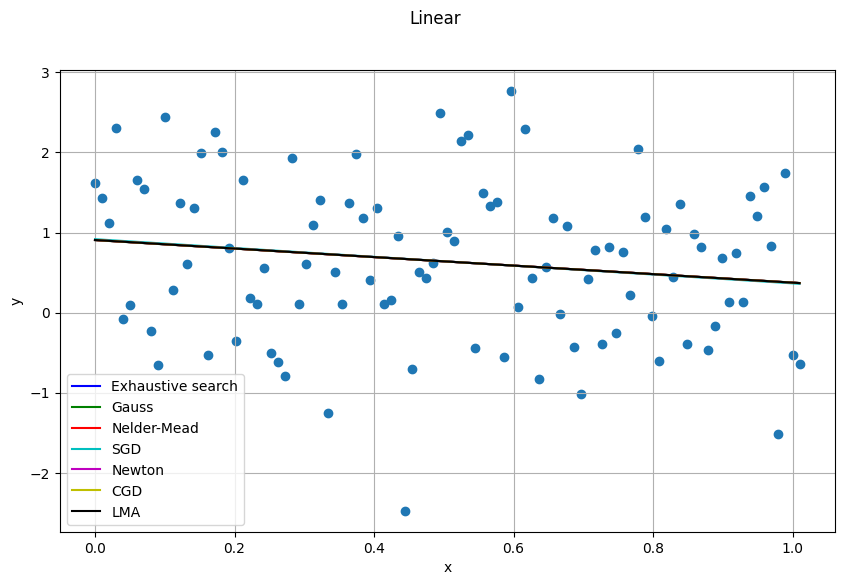

In [208]:
methods_and_coafs_full = {
    'Exhaustive search': brute_force_coafs,
    'Gauss': coord_descent_coefs,
    'Nelder-Mead': nelder_mead['x'],
    'SGD': [w, b],
    'Newton': newton_linear['x'],
    'CGD': conjugate_linear['x'],
    'LMA': lma_linear['x'],
}

plot_aprox_result(x, y, methods_and_coafs_full, linear, 'Linear', plot_full_only=True, figsize=(10,6))

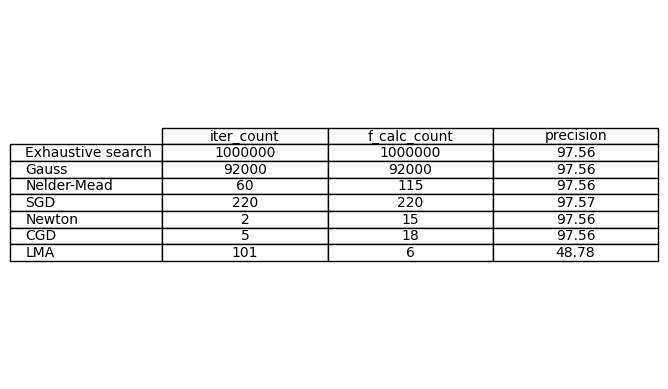

In [209]:
make_table_2d([brute_force_result,coordinate_descent_result,nelder_mead_result,SGD_result_linear, conjugate_result_linear, newton_result_linear, lma_result_linear],
               row_headers = list(methods_and_coafs.keys()) + list(methods_and_coafs_first_order.keys()),
               column_headers = ['iter_count','f_calc_count', 'precision'])

# Rational

[1.05731824 1.57139123]
[1.0460000000000003, 1.528]
[1.05734698 1.57154923]
[1.0502476461769794, 1.5372808953857828]
[1.05730987 1.5713342 ]
[1.05730844 1.57132653]
[1.05726899 1.57113345]


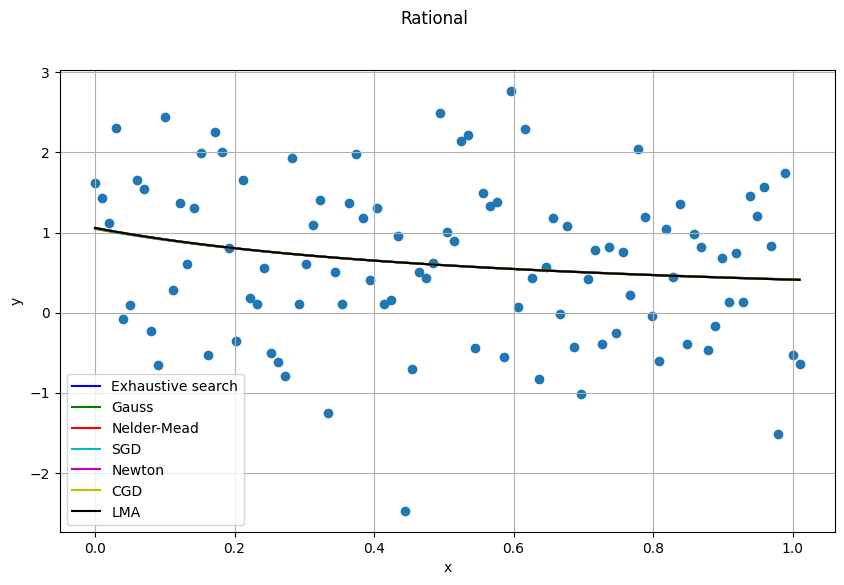

In [210]:
methods_and_coafs_full_rational = {
    'Exhaustive search': brute_force_coafs_rational,
    'Gauss': coord_descent_coefs_rational,
    'Nelder-Mead': nelder_mead_rational['x'],
    'SGD': [w_rational, b_rational],
    'Newton': newton_rational['x'],
    'CGD': conjugate_rational['x'],
    'LMA': lma_rational['x'],
}

plot_aprox_result(x, y, methods_and_coafs_full_rational, rational, 'Rational', plot_full_only=True, figsize=(10,6))

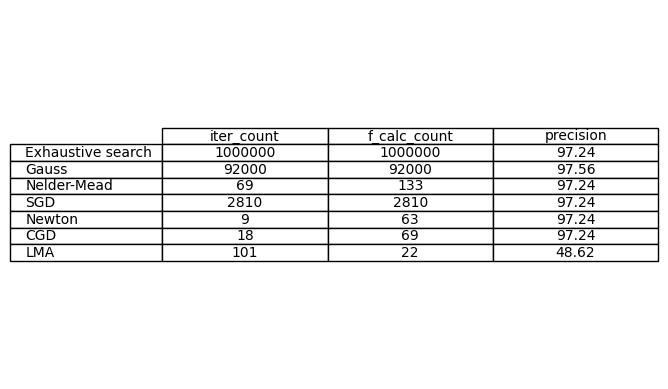

In [211]:
make_table_2d([brute_force_result_rational,
               coordinate_descent_result_rational,
               nelder_mead_result_rational,
               SGD_result_rational, 
               conjugate_result_rational,
               newton_result_rational,
               lma_result_rational],
               row_headers = list(methods_and_coafs_rational.keys()) + list(methods_and_coafs_rational_first_order.keys()),
               column_headers = ['iter_count','f_calc_count', 'precision'])